In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Effective field for chiral TBG model

Goal: use the same transformation as Morales-Durán et al. (https://arxiv.org/pdf/2308.03143.pdf) used to obtain Dirac Landau levels for a twisted bilayer graphene model.

In [3]:
class chiral_TBG:

    def __init__(self, modelParameters_, N, xMax):
        
        # note: angle \psi called \phi in GCs notes, but I have used \phi elsewhere now
        # note 2: k_theta is defined differently by a factor of \sqrt(3) compared to the Morales-Durán paper, following GCs notes
        self.psi, self.t, self.aM = modelParameters_
        self.k_theta = 4 * np.pi / (3 * self.aM)
        self.N = N
        self.xMax = abs(xMax)

        self.q1 = self.k_theta * np.array([0, -1])
        self.q2 = self.k_theta * np.array([np.sqrt(3)/2, 1/2])
        self.q3 = self.k_theta * np.array([-np.sqrt(3)/2, 1/2])
        self.G1 = self.q2 - self.q1
        self.G2 = self.q3 - self.q1

        self.xArray = np.linspace(-self.xMax, self.xMax, self.N, endpoint=True)
        self.yArray = np.linspace(-self.xMax, self.xMax, self.N, endpoint=True)
        self.xx, self.yy = np.meshgrid(self.xArray, self.yArray)

        self.fieldsDict = {}

    def SU2_gauge(self):

        # two vectors A_x and A_y
        self.A_x1 = np.zeros((self.N,self.N))
        self.A_x2 = np.zeros((self.N,self.N))
        self.A_y1 = np.zeros((self.N,self.N))
        self.A_y2 = np.zeros((self.N,self.N))
        for i in range(self.N):
                for j in range(self.N):
                    r = np.array([self.xx[i,j], self.yy[i,j]])
                    self.A_x1[i,j] = - self.t * (np.cos(np.vdot(self.q1, r)) + np.cos(self.psi) * (np.cos(np.vdot(self.q2, r)) + np.cos(np.vdot(self.q3, r))))

                    self.A_y1[i,j] = - self.t * (np.sin(np.vdot(self.q1, r)) + np.cos(self.psi) * (np.sin(np.vdot(self.q2, r)) + np.sin(np.vdot(self.q3, r))))

                    self.A_x2[i,j] = self.t * np.sin(self.psi) * (np.cos(np.vdot(self.q3, r)) - np.cos(np.vdot(self.q2, r)))

                    self.A_y2[i,j] = self.t * np.sin(self.psi) * (np.sin(np.vdot(self.q3, r)) - np.sin(np.vdot(self.q2, r)))
        
        self.A_1 = np.array([self.A_x1, self.A_y1])
        self.A_2 = np.array([self.A_x2, self.A_y2])
        
        # two magnitudes A1 and A2
        self.abs_A1 = np.linalg.norm(self.A_1, axis=0)
        self.abs_A2 = np.linalg.norm(self.A_2, axis=0)

        self.fieldsDict.update({
                                'A_x1': ['$\mathbf{A}_{x1}$', self.A_x1],
                                'A_x2': ['$\mathbf{A}_{x2}$', self.A_x2],
                                'A_y1': ['$\mathbf{A}_{y1}$', self.A_y1],
                                'A_y2': ['$\mathbf{A}_{y2}$', self.A_y2],
                                'A1': ['|$\mathbf{A}_1$|', self.abs_A1],
                                'A2': ['|$\mathbf{A}_2$|', self.abs_A2]
             })
        
    def angles(self):
        
        # vector a
        self.a = self.abs_A1 * self.A_2 + self.abs_A2 * self.A_2
        for i in range(self.N):
             for j in range(self.N):
                  if self.a[1,i,j] < 0:
                       self.a[:,i,j] *= -1

        self.a = self.a / np.linalg.norm(self.a, axis=0)

        # vector \delta: a rotated to the left by \pi / 2
        self.delta = np.array([-self.a[1], self.a[0]])
        
        # angle \theta
        self.theta = np.arccos(self.a[0])

        #angle \phi
        self.cosPhi = np.vdot(self.A_1, self.a) / self.abs_A1
        self.sinPhi = np.vdot(self.A_1, self.delta) / self.abs_A1

        self.phi = np.zeros((self.N,self.N))
        tol = 1e-3
        for i in range(self.N):
                for j in range(self.N):
                    if self.abs_A1[i,j] < tol or self.abs_A2[i,j] < tol:
                         self.phi[i,j] = 0

                    # if \sin(\phi) positive, we are between zero and pi, so then arccos will get the correct angle
                    elif self.sinPhi[i,j] >= 0:
                         self.phi[i,j] = np.arccos(self.cosPhi[i,j])
                    else:
                         self.phi[i,j] = - np.arccos(self.cosPhi[i,j])

        self.cosPhi2 = np.vdot(self.A_2, self.a) / self.abs_A2
        self.sinPhi2 = np.vdot(self.A_2, self.delta) / self.abs_A2

        self.phi2 = np.zeros((self.N,self.N))
        tol = 1e-3
        for i in range(self.N):
                for j in range(self.N):
                    if self.abs_A1[i,j] < tol or self.abs_A2[i,j] < tol:
                         self.phi2[i,j] = 0

                    # if \sin(\phi) positive, we are between zero and pi, so then arccos will get the correct angle
                    elif self.sinPhi2[i,j] >= 0:
                         self.phi2[i,j] = np.arccos(self.cosPhi2[i,j])
                    else:
                         self.phi2[i,j] = - np.arccos(self.cosPhi2[i,j])

        self.fieldsDict.update({'theta': ['$\\theta / \pi$', self.theta / np.pi],
                                'phi': ['$\\phi / \pi$', self.phi / np.pi],
                                'phi2': ['$\\phi / \pi$', self.phi2 / np.pi]
                                
                                })
    

    # Plots using fieldsDict dictionary to get both field and its name for the title

    def plot(self, field, levels):
        fig, ax = plt.subplots(layout='constrained')

        ax.set_aspect('equal')
        ax.set_title(self.fieldsDict[field][0])
        ax.set_xlabel('$x/a_M$')
        ax.set_ylabel('$y/a_M$')
        contours = ax.contourf(self.xx / self.aM, self.yy / self.aM, self.fieldsDict[field][1], levels, cmap='Spectral_r')
        cbar = fig.colorbar(contours)
        plt.show()

In [4]:
parameters = [2 * np.pi / 3, 1, 1]
bilayer = chiral_TBG(parameters, 100, 1.5)
bilayer.SU2_gauge()
bilayer.angles()


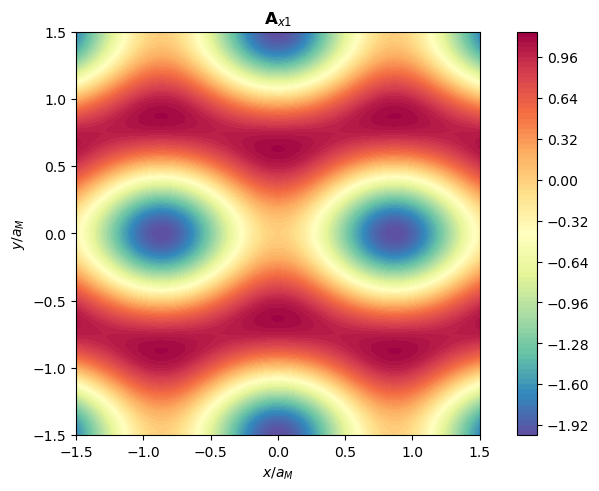

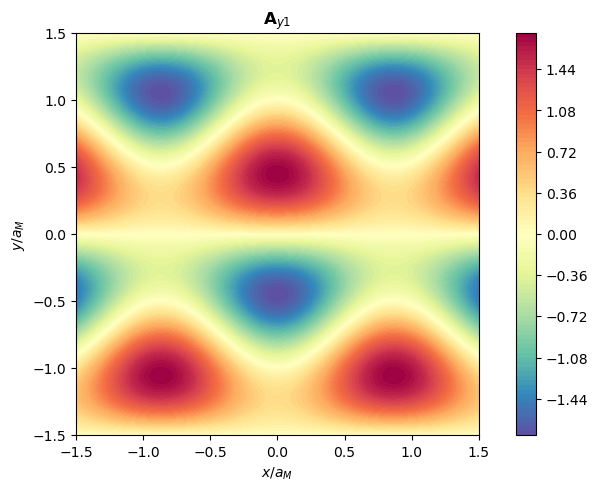

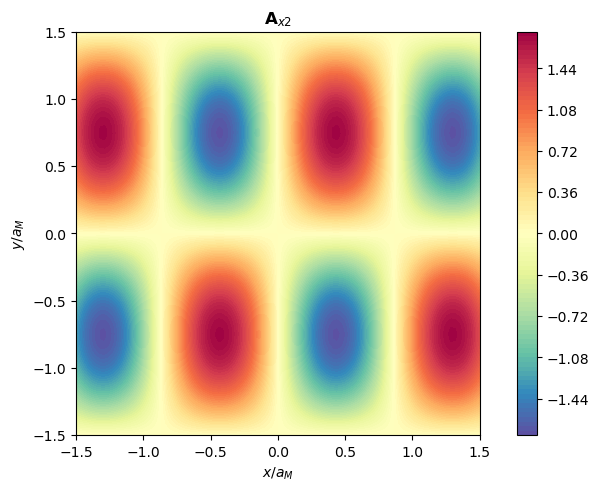

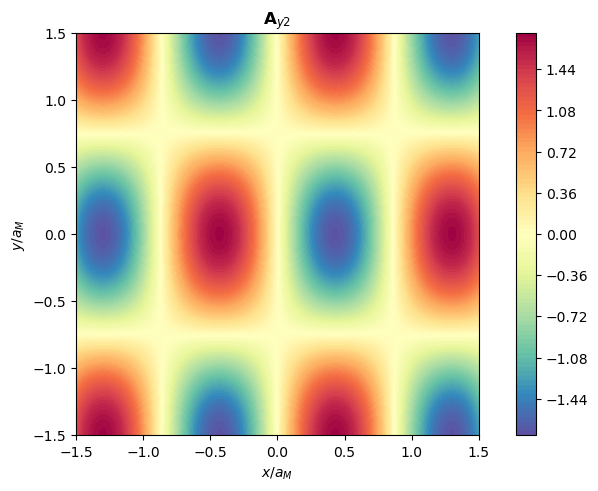

[[1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
 ...
 [1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]]


In [6]:
bilayer.plot('A_x1',100)
bilayer.plot('A_y1',100)
bilayer.plot('A_x2',100)

bilayer.plot('A_y2',100)

print(bilayer.phi2)
